In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#This purpose of this code is to use Haar cascade to scan the faces from images and use 
test_image_ori = cv2.imread('/Users/lychee/Documents/Data Science Projects/Datasets/Sample Image.jpg')

In [4]:
test_image_ori.shape
# Shows 3 at the end because it uses the keys RGB

(360, 700, 3)

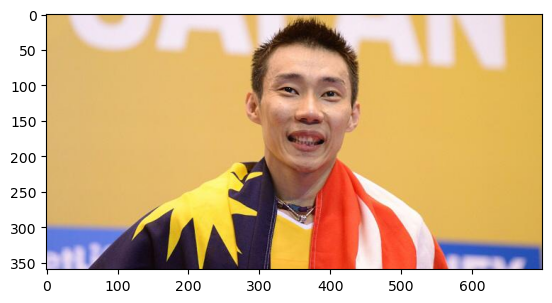

In [6]:
cv2.imshow('Image Window', test_image_ori)
test_image = cv2.cvtColor(test_image_ori, cv2.COLOR_BGR2RGB)
# cv reads images as BGR and matplotlib displays as RBG so we convert BGR to RGB
plt.imshow(test_image)
plt.show()

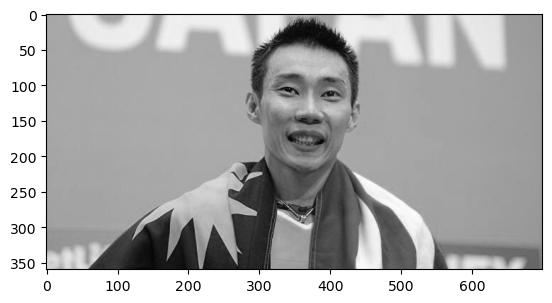

In [8]:
grey_test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
# convert to greyscale becuase haar cascade works best with grey images
plt.imshow(grey_test_image, cmap = 'gray')
plt.show()

In [10]:
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_eye_tree_eyeglasses.xml')

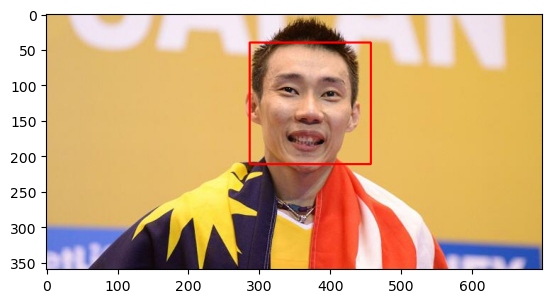

In [12]:
faces = face_cascade.detectMultiScale(grey_test_image, 1.3, 5)
face_detect = test_image.copy()
for face in faces:
    x,y,p1,p2 = face
    face_detect = cv2.rectangle(face_detect,(x,y),(x+p1,y+p2),(255,0,0),2)
plt.imshow(face_detect)
plt.show()

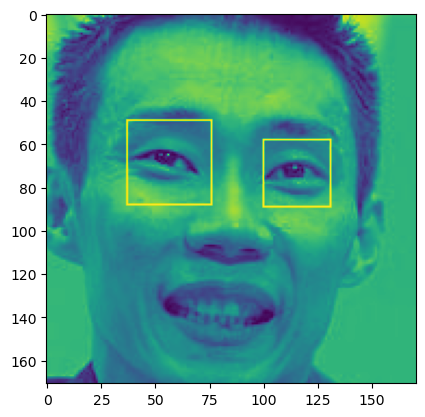

In [14]:
roi_gray = grey_test_image[y:y+p2, x:x+p1]
eyes = eye_cascade.detectMultiScale(roi_gray, scaleFactor=1.1, minNeighbors=6)
# minNeighbours measures how sensitive I want the model to be and scaleFactor measures how 
for ex,ey,ep1,ep2 in eyes:
    eyes_detect = cv2.rectangle(roi_gray,(ex,ey),(ex+ep1,ey+ep2),(255,0,0),1)
plt.imshow(eyes_detect)
plt.show()

In [16]:
def get_cropped_image_if_2_eyes(image_path):
    out = []
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image at {image_path}")
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray, scaleFactor=1.1, minNeighbors=6)
        if len(eyes) >= 2:
            out.append(roi_color)
    if len(out)>=1:
        return out
    return None

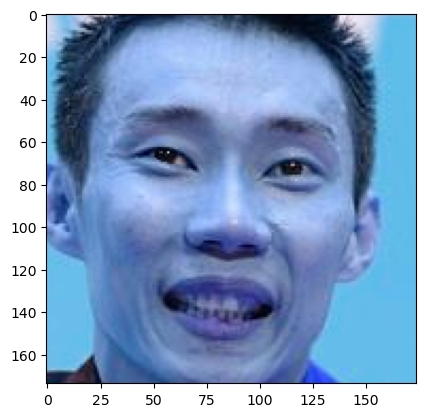

In [18]:
cropped_image_test = get_cropped_image_if_2_eyes('/Users/lychee/Documents/Data Science Projects/Datasets/Sample Image.jpg')
#out is an array of images, we need to index it to 0 to get the image due to the nature of the function above
plt.imshow(cropped_image_test[0])
plt.show()

In [20]:
path_to_data = './Datasets/'
path_to_cropped = './Cropped/'            

In [38]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
# get all the directory names for the images

In [40]:
import shutil
if os.path.exists(path_to_cropped):
     shutil.rmtree(path_to_cropped)
os.mkdir(path_to_cropped)

In [42]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    celebrity_file_names_dict[celebrity_name] = []
# create a dictionary with names and a list of images
    
    for entry in os.scandir(img_dir):
        roi_colors = get_cropped_image_if_2_eyes(entry.path)
        if roi_colors is not None:
            for roi_color in roi_colors:
                cropped_folder = path_to_cropped + celebrity_name
                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)
                    cropped_image_dirs.append(cropped_folder)
                    print("Generating cropped images in folder: ",cropped_folder)
                    
                cropped_file_name = celebrity_name + str(count) + ".png"
                cropped_file_path = cropped_folder + "/" + cropped_file_name 
                
                cv2.imwrite(cropped_file_path, roi_color)
                celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
                count += 1    

Ronaldo
Generating cropped images in folder:  ./Cropped/Ronaldo
Error: Unable to load image at ./Datasets/Ronaldo/.DS_Store
lionel_messi
Generating cropped images in folder:  ./Cropped/lionel_messi
Error: Unable to load image at ./Datasets/lionel_messi/.DS_Store
Chee Seng
Error: Unable to load image at ./Datasets/Chee Seng/.DS_Store
Generating cropped images in folder:  ./Cropped/Chee Seng
Karina
Generating cropped images in folder:  ./Cropped/Karina
Error: Unable to load image at ./Datasets/Karina/.DS_Store


In [44]:
import cv2
import pywt
import numpy as np

#This code defines a function w2d that takes an image and applies wavelet transform-based denoising
#or feature extraction, returning a new image with only high-frequency components (like edges and textures)
def wavelet_trans(img, mode='haar', level=1):
    if img is None or not isinstance(img, np.ndarray):
        raise ValueError("Input image is invalid or None.")
    #Convert the image to greyscale
    imArray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #Convert the pixel values from a range of 0-255 to 0.0-1.0
    imArray = np.float32(imArray) / 255.0
    coeffs = pywt.wavedec2(imArray, mode, level=level)
    coeffs_H = list(coeffs)
    #Set low frequency to zero to supress smooth areas and retain only edges or textures
    coeffs_H[0] *= 0
    #Reconstruct the image using only high frequency details
    imArray_H = pywt.waverec2(coeffs_H, mode)
    #Convert pixel values back to 0-255
    imArray_H *= 255
    return np.uint8(imArray_H)

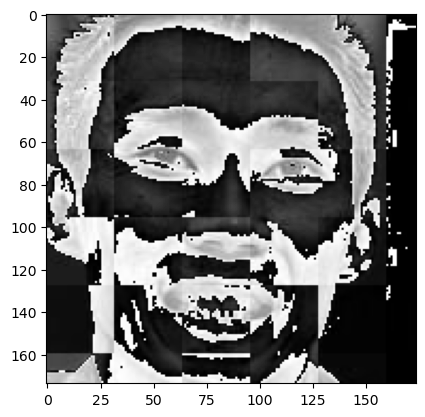

In [46]:
im_har = wavelet_trans(cropped_image_test[0], 'db1', 5)
plt.imshow(im_har, cmap = 'grey')
plt.show()

In [48]:
#Get the number of images per celebrity
class_dict = {}
imag_counter = 0
for celeb_name in celebrity_file_names_dict.keys():
    class_dict[celeb_name] = count
    count += 1
class_dict

{'Ronaldo': 17, 'lionel_messi': 18, 'Chee Seng': 19, 'Karina': 20}

In [50]:
#Initialize empty lists for input features (X) and labels/names (y)
X, y = [], []
for celeb_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            print("Image deleted during cleaning, skipping image")
            continue
        #Resize the raw color image to 32x32
        scalled_raw_img = cv2.resize(img, (32,32))
        img_har = wavelet_trans(img, 'db1', 5)
        #Resize the wavelet-transformed image to 32x32
        scalled_img_haar = cv2.resize(img_har, (32,32))
        #Verticle stack original image and transformed image so model can train on both
        #Color helps distinguish appearances
        #Wavelet features help detect patterns like edges, textures, and shapes
        comb_img = np.vstack((
            scalled_raw_img.reshape(32*32*3, 1),
            scalled_img_haar.reshape(32*32, 1)
        ))
        X.append(comb_img)
        y.append(class_dict[celeb_name])

Image deleted during cleaning, skipping image
Image deleted during cleaning, skipping image
Image deleted during cleaning, skipping image
Image deleted during cleaning, skipping image


[ WARN:0@1348.594] global loadsave.cpp:268 findDecoder imread_('./Cropped/lionel_messi/lionel_messi7.png'): can't open/read file: check file path/integrity
[ WARN:0@1348.596] global loadsave.cpp:268 findDecoder imread_('./Cropped/lionel_messi/lionel_messi9.png'): can't open/read file: check file path/integrity
[ WARN:0@1348.600] global loadsave.cpp:268 findDecoder imread_('./Cropped/lionel_messi/lionel_messi15.png'): can't open/read file: check file path/integrity
[ WARN:0@1348.608] global loadsave.cpp:268 findDecoder imread_('./Cropped/lionel_messi/lionel_messi22.png'): can't open/read file: check file path/integrity


In [52]:
len(X)

72

In [54]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(72, 4096)

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0
)

#Test it with all parameters for SVC (updated from SVM, this has higher accuracy)
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__gamma': ['scale', 'auto']
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.score(X_test, y_test))

{'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
0.8888888888888888


In [66]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=0.1, gamma='scale', kernel='linear'))
])
pipe.fit(X_train, y_train)

print(pipe.score(X_test, y_test))

0.8888888888888888


In [72]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          17       0.50      1.00      0.67         1
          18       0.88      0.88      0.88         8
          19       1.00      1.00      1.00         4
          20       1.00      0.80      0.89         5

    accuracy                           0.89        18
   macro avg       0.84      0.92      0.86        18
weighted avg       0.92      0.89      0.90        18



In [74]:
import joblib

In [76]:
joblib.dump(pipe, '/Users/lychee/Documents/Data Science Projects/Model/svc_pipeline_model.joblib')

['/Users/lychee/Documents/Data Science Projects/Model/svc_pipeline_model.joblib']